In [53]:
import os
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator


In [54]:
benign_dirs = [
    r'Oral Images Dataset\augmented_data\augmented_benign'
]


malignant_dirs = [
    r'Oral Images Dataset\augmented_data\augmented_malignant'
]

filepaths = []
labels = []
dict_lists = [benign_dirs, malignant_dirs]
class_labels = ['benign lesions', 'malignant lesions']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
oral_data = pd.concat([Fseries, Lseries], axis=1)
oral_df = pd.DataFrame(oral_data)
print(oral_df.head())
print(oral_df["labels"].value_counts())

                                           filepaths          labels
0  Oral Images Dataset\augmented_data\augmented_b...  benign lesions
1  Oral Images Dataset\augmented_data\augmented_b...  benign lesions
2  Oral Images Dataset\augmented_data\augmented_b...  benign lesions
3  Oral Images Dataset\augmented_data\augmented_b...  benign lesions
4  Oral Images Dataset\augmented_data\augmented_b...  benign lesions
labels
benign lesions       1155
malignant lesions    1115
Name: count, dtype: int64


In [55]:
train_images, test_images = train_test_split(oral_df, test_size=0.3, random_state=31)
train_set, val_set = train_test_split(oral_df, test_size=0.2, random_state=31)

In [56]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1816, 2)
(681, 2)
(454, 2)
(1589, 2)


In [57]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

In [58]:
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=4,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1816 validated image filenames belonging to 2 classes.
Found 681 validated image filenames belonging to 2 classes.
Found 454 validated image filenames belonging to 2 classes.


In [59]:
classes=list(train.class_indices.keys())
print (classes)

['benign lesions', 'malignant lesions']


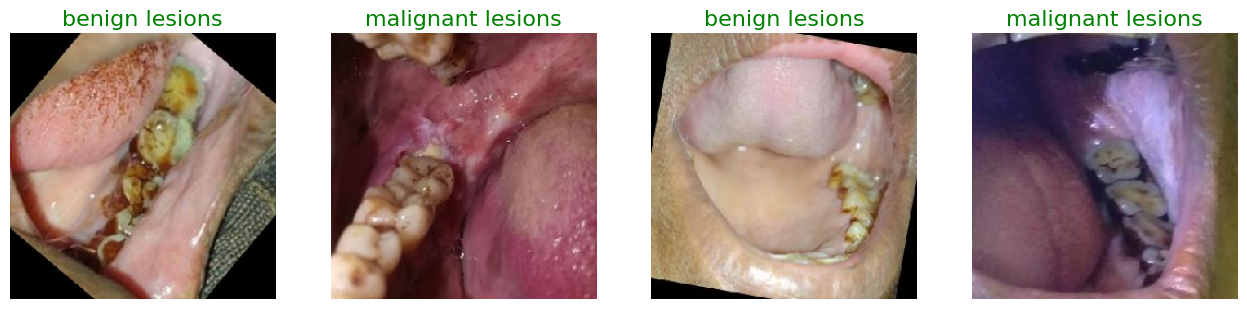

In [60]:
images, labels=next(train)

plt.figure(figsize=(20, 20))
for i in range(4):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
plt.show()

In [61]:
from tensorflow.keras.optimizers import Adamax

img_shape=(224,224,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')


    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(2, activation= 'sigmoid')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 21124010 (80.58 MB)
Trainable params: 21

In [62]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [63]:
import tensorflow as tf 

class StopTrainingCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.99):
        super(StopTrainingCallback, self).__init__()
        self.target_accuracy = target_accuracy
        self.highest_val_accuracy = 0

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') is not None:
            current_val_accuracy = logs.get('val_accuracy')
            if current_val_accuracy > self.highest_val_accuracy:
                self.highest_val_accuracy = current_val_accuracy

            print(f"\nEpoch {epoch + 1}/{self.params['epochs']}, "
                  f"Validation Accuracy: {current_val_accuracy:.4f}, "
                  f"Highest Validation Accuracy: {self.highest_val_accuracy:.4f}")

            if current_val_accuracy >= self.target_accuracy:
                print(f"Reached {self.target_accuracy * 100:.2f}% validation accuracy, stopping training.")
                self.model.stop_training = True


history = model.fit(train, epochs=5, validation_data=val, verbose=1, callbacks=[StopTrainingCallback()])

Epoch 1/5
454/454 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8282
Epoch 1/5, Validation Accuracy: 0.9339, Highest Validation Accuracy: 0.9339
454/454 [==============================] - 790s 2s/step - loss: 0.3776 - accuracy: 0.8282 - val_loss: 0.1613 - val_accuracy: 0.9339
Epoch 2/5
454/454 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9471
Epoch 2/5, Validation Accuracy: 0.9097, Highest Validation Accuracy: 0.9339
454/454 [==============================] - 742s 2s/step - loss: 0.1330 - accuracy: 0.9471 - val_loss: 0.2432 - val_accuracy: 0.9097
Epoch 3/5
454/454 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9791
Epoch 3/5, Validation Accuracy: 0.9626, Highest Validation Accuracy: 0.9626
454/454 [==============================] - 736s 2s/step - loss: 0.0624 - accuracy: 0.9791 - val_loss: 0.1403 - val_accuracy: 0.9626
Epoch 4/5
454/454 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9

In [64]:
model.evaluate(test, verbose=1)


171/171 [==============================] - 44s 259ms/step - loss: 0.0748 - accuracy: 0.9765


[0.0748191773891449, 0.9765051603317261]

In [66]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

171/171 [==============================] - 59s 337ms/step


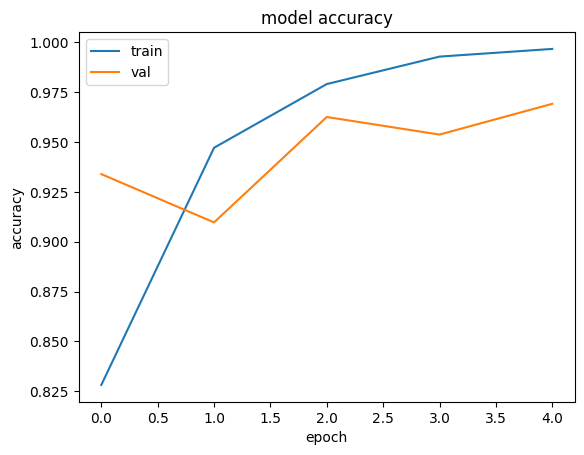

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score

img_labels = test_images.labels
print(classification_report(img_labels, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(img_labels, pred2)*100))

                   precision    recall  f1-score   support

   benign lesions       0.98      0.98      0.98       348
malignant lesions       0.98      0.98      0.98       333

         accuracy                           0.98       681
        macro avg       0.98      0.98      0.98       681
     weighted avg       0.98      0.98      0.98       681

Accuracy of the Model: 97.7%


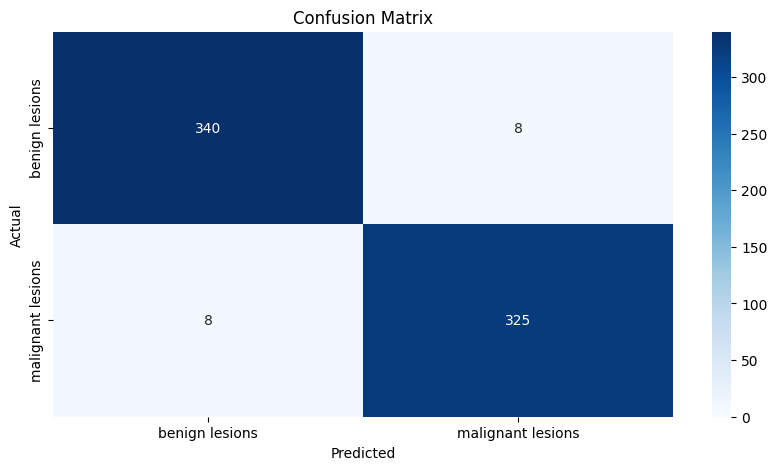

In [69]:
import seaborn as sns 

cm = confusion_matrix(img_labels, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()